[View in Colaboratory](https://colab.research.google.com/github/sleepless-se/Abstract/blob/master/stock_filter_015.ipynb)

##新しく作り直した学習データを使って学習



In [22]:

!apt-get install mecab
!apt-get install libmecab-dev
!apt-get install mecab-ipadic-utf8
!pip install mecab-python3

Reading package lists... Done
Building dependency tree       
Reading state information... Done
mecab is already the newest version (0.996-3.1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libmecab-dev is already the newest version (0.996-3.1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
mecab-ipadic-utf8 is already the newest version (2.7.0-20070801+main-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [0]:
import sys
import MeCab
from keras.datasets import boston_housing
from keras.models import Model,model_from_json
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import keras
from keras.datasets import mnist
from keras import models
from keras import layers
import time
import numpy as np
from google.colab import files
import re
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.metrics import categorical_accuracy

mecab = MeCab.Tagger ("-Owakati")

In [24]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/gdrive')

# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
base_dir = "/content/gdrive/My Drive/data/stock_filter/015"
!ls base_dir

Mounted at /content/gdrive
ls: cannot access 'base_dir': No such file or directory


In [69]:
import pandas as pd

file_name = 'stock_label.csv'
stock_df = pd.read_csv("{}/{}".format(base_dir,file_name),sep=',',error_bad_lines=False,dtype={"iid": str,"style": str, "text": str})

file_name = 'vari_color_label.csv'
vari_df = pd.read_csv("{}/{}".format(base_dir,file_name),sep=',',error_bad_lines=False,dtype={"iid": str,"style": str, "text": str})

file_name = 'null_label.csv'
null_df = pd.read_csv("{}/{}".format(base_dir,file_name),sep=',',error_bad_lines=False,dtype={"iid": str,"style": str, "text": str})
null_df["label"] = "skip"
df0 = stock_df.append(vari_df, ignore_index=True)
df0 = df0.append(null_df, ignore_index=True)
df0.columns


b'Skipping line 166: expected 29 fields, saw 31\nSkipping line 873: expected 29 fields, saw 98\nSkipping line 984: expected 29 fields, saw 2539\nSkipping line 1141: expected 29 fields, saw 43\nSkipping line 1306: expected 29 fields, saw 37\nSkipping line 1720: expected 29 fields, saw 2563\nSkipping line 2169: expected 29 fields, saw 2542\nSkipping line 2552: expected 29 fields, saw 125\nSkipping line 2616: expected 29 fields, saw 34\nSkipping line 3529: expected 29 fields, saw 733\nSkipping line 4302: expected 29 fields, saw 70\nSkipping line 4327: expected 29 fields, saw 33\nSkipping line 4556: expected 29 fields, saw 81\nSkipping line 4966: expected 29 fields, saw 445\nSkipping line 5046: expected 29 fields, saw 2572\nSkipping line 5166: expected 29 fields, saw 2515\nSkipping line 5274: expected 29 fields, saw 33\nSkipping line 5827: expected 29 fields, saw 299\nSkipping line 5849: expected 29 fields, saw 37\nSkipping line 5873: expected 29 fields, saw 61\nSkipping line 5989: expecte

Index(['alt', 'disable', 'height', 'href', 'id', 'iid', 'label', 'p_height',
       'p_iid', 'p_style', 'p_tag', 'p_width', 'p_x', 'p_y', 'page_id',
       'pp_height', 'pp_iid', 'pp_style', 'pp_tag', 'pp_width', 'pp_x', 'pp_y',
       'src', 'style', 'tag', 'text', 'width', 'x', 'y'],
      dtype='object')

In [0]:

def add_space_front_uppercase(text:str)->str:
  return ''.join(' ' + char if char.isupper() else char.strip() for char in text).strip()

def add_space_color_size(text:str)->str:
  return text.replace("color"," color ").replace("size"," size ")


def tag_filter(tag:str)->str:
  tags = ["option","li","div","span"]
  tag = tag if tag in tags else "0"
  return tag

def wakati(text)->str:
  text = str(text)
  if len(text)>3:
    text = mecab.parse(text)
  return replace_numbers_to_0(text)

def replace_numbers_to_0(text:str)->str:
  return re.sub(r'[0-9]+', "0",str(text))
wakachi_fileds = ['alt', 'href', 'iid','p_iid', 'p_style', 'p_tag', 'pp_iid', 'pp_style', 'pp_tag','src', 'style', 'tag', 'text']
df0[wakachi_fileds] = df0[wakachi_fileds].applymap(lambda x : wakati(x)).fillna("")

add_space_fileds = ["iid","style","p_iid","p_style","pp_iid","pp_style"]
df0[add_space_fileds] = df0[add_space_fileds].applymap(lambda x : add_space_front_uppercase(x))
df0[add_space_fileds] = df0[add_space_fileds].applymap(lambda x : add_space_color_size(x))
                           

# df0["tag"] = df0[["tag"]].applymap(lambda x : tag_filter(x))

ラベルが無い項目を削減

In [71]:
df = df0

# df.shape
# lis = df["label"].isnull()
# df_null = df[lis]
# df_null = df_null[0:90000]
# print(df_null.shape)

# df = df.drop(df[lis].index)
# print(df.shape)
# df_null["label"] = "skip"
# df = df.append(df_null)

print(df.shape)


(66634, 29)


In [72]:
df[101:103].to_json(orient='records')

'[{"alt":"nan","disable":null,"height":0,"href":"nan","id":1951759,"iid":"nan","label":"stock","p_height":40,"p_iid":"nan","p_style":"select-option-style","p_tag":"SELECT \\n","p_width":224,"p_x":777,"p_y":599,"page_id":3013,"pp_height":40,"pp_iid":"nan","pp_style":"product- size -selectionselect-option-style__containerthree Selection Itemsjs- size -select","pp_tag":"DIV","pp_width":226,"pp_x":766,"pp_y":598,"src":"nan","style":"nan","tag":"OPTION \\n","text":"EU 0 ( UK 0 ) - Only one left \\n","width":0,"x":0,"y":0},{"alt":"nan","disable":null,"height":26,"href":"nan","id":1953214,"iid":"nan","label":"stock","p_height":108,"p_iid":"nan","p_style":"nan","p_tag":"UL","p_width":470,"p_x":517,"p_y":321,"page_id":876,"pp_height":108,"pp_iid":"nan","pp_style":"H T M L List Size Selector","pp_tag":"DIV","pp_width":470,"pp_x":517,"pp_y":321,"src":"nan","style":"is-last Item","tag":"LI","text":"US 0 - One left \\n","width":70,"x":517,"y":326}]'

In [73]:
X = df

# slect only int fileds
fields = ['x', 'y', 'height', 'width']
fields = ['height', 'width', 'x', 'y',  'p_x', 'p_y', 'p_width','p_height','pp_height', 'pp_width', 'pp_x', 'pp_y']
X = df[fields]
print(X.columns)
print(X.shape)
# X[X["height"]==32]

Index(['height', 'width', 'x', 'y', 'p_x', 'p_y', 'p_width', 'p_height',
       'pp_height', 'pp_width', 'pp_x', 'pp_y'],
      dtype='object')
(66634, 12)


In [0]:
import pickle

def tokanaize(df,filed,num_words = None):
  token = None
  # tokanizer
  if num_words == None:
    token = Tokenizer(lower=True)
  else:
    token = Tokenizer(lower=True,num_words=num_words) 
  token.fit_on_texts(df[filed])
  print(token.word_counts)
  
  import pickle

  # saving
  file_name = '{}/tokenizer_{}.pickle'.format(base_dir,filed)
  with open(file_name, 'wb') as handle:
      pickle.dump(token, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)
  
  # word count   
  words_count = len(token.word_counts) +1
  print("{} words".format(words_count))
  if num_words != None:words_count = num_words
  
  
  columns = ["{}{}".format(filed,i) for i in range(words_count)]
  text_matrix = token.texts_to_matrix(df[filed] ,mode='count')
  df_iid = pd.DataFrame(text_matrix)
  df_iid.columns = columns
  return df_iid

In [75]:
df_tag = tokanaize(df,"tag")
X = X.join(df_tag)
print(X.columns)
print(X.shape)
df_tag = tokanaize(df,"p_tag")
X = X.join(df_tag)
print(X.columns)
print(X.shape)
df_tag = tokanaize(df,"pp_tag")
X = X.join(df_tag)
print(X.columns)
print(X.shape)

OrderedDict([('option', 11424), ('li', 16396), ('span', 12112), ('div', 11044), ('label', 610), ('a', 10519), ('button', 419), ('img', 1459), ('aside', 51), ('ul', 1178), ('p', 183), ('section', 207), ('i', 257), ('meta', 35), ('h0', 330), ('svg', 33), ('strong', 115), ('noscript', 33), ('input', 87), ('hr', 11), ('small', 8), ('use', 28), ('form', 23), ('br', 23), ('link', 17), ('source', 13), ('select', 9), ('u', 3), ('path', 4), ('nav', 2), ('picture', 1)])
32 words
Index(['height', 'width', 'x', 'y', 'p_x', 'p_y', 'p_width', 'p_height',
       'pp_height', 'pp_width', 'pp_x', 'pp_y', 'tag0', 'tag1', 'tag2', 'tag3',
       'tag4', 'tag5', 'tag6', 'tag7', 'tag8', 'tag9', 'tag10', 'tag11',
       'tag12', 'tag13', 'tag14', 'tag15', 'tag16', 'tag17', 'tag18', 'tag19',
       'tag20', 'tag21', 'tag22', 'tag23', 'tag24', 'tag25', 'tag26', 'tag27',
       'tag28', 'tag29', 'tag30', 'tag31'],
      dtype='object')
(66634, 44)
OrderedDict([('select', 11424), ('ul', 16364), ('div', 12458), (

In [76]:
df_iid = tokanaize(df,"iid",25)
X = X.join(df_iid)
print(X.columns)
print(X.shape)
df_iid = tokanaize(df,"p_iid",25)
X = X.join(df_iid)
print(X.columns)
print(X.shape)
df_iid = tokanaize(df,"pp_iid",25)
X = X.join(df_iid)
print(X.columns)
print(X.shape)


OrderedDict([('nan', 62667), ('l', 409), ('0', 1094), ('intl', 3458), ('clothing', 758), ('ten', 7), ('key', 20), ('pieces', 7), ('shoes', 334), ('classics', 13), ('boutique', 15), ('js', 92), ('ydialog', 5), ('dialog', 5), ('cache', 5), ('denim', 22), ('latest', 6), ('result', 8), ('title', 10), ('gigya', 7), ('share', 30), ('reaction0', 7), ('facebook', 7), ('img', 53), ('thumbnail', 4), ('image', 49), ('workwear', 416), ('list', 426), ('shopping', 14), ('basket', 13), ('just', 384), ('in', 384), ('what', 393), ('to', 423), ('wear', 393), ('page', 417), ('recently', 8), ('viewed', 8), ('df', 7), ('header', 42), ('dfclassic', 8), ('layer', 55), ('first', 22), ('visit', 24), ('container', 110), ('jackets', 36), ('leather', 11), ('sneakers', 19), ('accessories', 366), ('wallets', 12), ('chrome', 4), ('sticky', 3), ('generic', 3), ('shipping', 15), ('text', 31), ('designers', 958), ('valentino', 33), ('sigerson', 10), ('morrison', 10), ('uuid', 93), ('0b0ff0', 3), ('cb0', 3), ('0e0d', 3)

In [77]:
df_style = tokanaize(df,"style",75)
X = X.join(df_style)
print(X.columns)
print(X.shape)
df_style = tokanaize(df,"p_style",75)
X = X.join(df_style)
print(X.columns)
print(X.shape)
df_style = tokanaize(df,"pp_style",75)
X = X.join(df_style)
print(X.columns)
print(X.shape)
# X[0:10]

OrderedDict([('nan', 31697), ('is', 3086), ('last', 1121), ('item', 6072), ('limited', 743), ('availability', 898), ('disabledis', 1074), ('sold', 1381), ('out', 1355), ('in', 1587), ('stock', 1562), ('product', 1790), ('size', 960), ('disabled', 219), ('outis', 60), ('itemis', 7), ('selected', 664), ('delayed', 4), ('select', 255), ('color', 1636), ('label', 620), ('js', 865), ('track', 691), ('me', 418), ('ta', 303), ('itempage', 284), ('0', 2563), ('colour', 93), ('selectionis', 559), ('selectedis', 24), ('selection', 157), ('active', 422), ('swatchjs', 84), ('swatch', 84), ('link', 999), ('icon', 3425), ('text', 4030), ('register', 16), ('button', 312), ('container', 661), ('ten', 7), ('key', 20), ('piecesmenu', 7), ('save', 14), ('overlay', 124), ('has', 546), ('childrenmenu', 367), ('hide', 83), ('textsocial', 43), ('media', 64), ('iconicon', 60), ('google', 45), ('plus', 45), ('classics', 13), ('boutiquemenu', 13), ('value', 70), ('secondary', 61), ('navigation', 1174), ('depart

Index(['alt', 'disable', 'height', 'href', 'id', 'iid', 'label', 'p_height',
       'p_iid', 'p_style', 'p_tag', 'p_width', 'p_x', 'p_y', 'page_id',
       'pp_height', 'pp_iid', 'pp_style', 'pp_tag', 'pp_width', 'pp_x', 'pp_y',
       'src', 'style', 'tag', 'text', 'width', 'x', 'y'],
      dtype='object')

In [78]:
df_style = tokanaize(df,"alt",75)
X = X.join(df_style)
print(X.columns)
print(X.shape)
df_style = tokanaize(df,"src",75)
X = X.join(df_style)
print(X.columns)
print(X.shape)
df_style = tokanaize(df,"href",75)
X = X.join(df_style)
print(X.columns)
print(X.shape)
# X[0:10]

OrderedDict([('nan', 66592), ('fendi', 42), ('peekaboo', 2), ('x', 2), ('lite', 2), ('white', 8), ('leather', 13), ('bag', 7), ('view', 42), ('0', 42), ('detail', 30), ('overcoat', 1), ('brown', 3), ('camel', 1), ('coat', 5), ('thumbnail', 12), ('dress', 2), ('micro', 1), ('check', 2), ('wool', 8), ('skirt', 6), ('prince', 1), ('of', 1), ('wales', 1), ('mini', 2), ('bomber', 4), ('fabric', 7), ('and', 8), ('fur', 3), ('jacket', 2), ('duffel', 1), ('sneakers', 16), ('black', 7), ('tech', 4), ('high', 5), ('tops', 5), ('pullover', 1), ('mohair', 1), ('jumper', 1), ('trousers', 2), ('red', 1), ('blue', 3), ('knit', 3), ('top', 1), ('belt', 3), ('multicolour', 9), ('sheepskin', 2), ('running', 1), ('shoes', 4), ('pumps', 1), ('burgundy', 1), ('court', 3), ('slides', 2), ('tpu', 2), ('fussbetts', 2), ('scarf', 6), ('cashmere', 1), ('nylon', 2), ('umbrella', 1), ('hat', 2), ('beige', 5), ('technical', 2), ('mesh', 2), ('vinyl', 2), ('denim', 2), ('slip', 1), ('ons', 1), ('yellow', 1), ('back

In [79]:
df_style = tokanaize(df,"text",num_words=100)
X = X.join(df_style)
print(X.columns)
print(X.shape)

OrderedDict([('eu', 8617), ('0', 48123), ('sold', 1770), ('out', 2577), ('uk', 6059), ('only', 2716), ('in', 4608), ('boutique', 1307), ('one', 2730), ('left', 2528), ('low', 925), ('stock', 1101), ('us', 2748), ('small', 195), ('medium', 23), ('large', 73), ('x', 186), ('nan', 11704), ('not', 641), ('available', 603), ('売り切れ', 225), ('スモール', 8), ('ミディアム', 6), ('ラージ', 16), ('ワイド', 519), ('wide', 61), ('fit', 397), ('m', 948), ('l', 1984), ('s', 5204), ('xs', 55), ('～', 4), ('週間', 50), ('以内', 3), ('に', 457), ('発送', 3), ('いたし', 3), ('ます', 200), ('xl', 23), ('xxl', 10), ('xxxl', 9), ('xxs', 10), ('order', 797), ('now', 662), ('for', 1876), ('delivery', 516), ('within', 69), ('weeks', 1), ('xx', 14), ('シルバー', 19), ('ブラウン', 13), ('ホワイト', 45), ('パステル', 1), ('ブルー', 17), ('レッド', 25), ('フューシャ', 4), ('サンド', 6), ('ブラック', 214), ('ベージュ', 5), ('オークル', 18), ('モーブ', 2), ('コーラル', 11), ('ピンク', 26), ('カッ', 10), ('パー', 11), ('プラチナ', 4), ('グリーン', 16), ('カーキ', 6), ('赤茶色', 2), ('アジュールブルー', 3), ('スカイ', 2), ('

In [0]:
X = X.fillna(0)
# X

In [0]:

y = df["label"]
y_label = list(set(df["label"]))


In [82]:


# def label_filter(text:str)->str:
#   label = ["stock","outofstock","vari","color","skip"]
# #   label = ["stock","variat"]
#   lis=[]
#   if text in y_label:
#     return text
#   else:
#     return ""

# y = list(map(label_filter,y))


label_token = Tokenizer()
label_token.fit_on_texts(y)
label_dic= {v: k for k, v in label_token.word_index.items()}
label_dic[0]=""
print(label_dic)
# y = list(map(lambda y : token.word_index.get(y),y))
y = label_token.texts_to_matrix(y)

{1: 'skip', 2: 'stock', 3: 'vari', 4: 'color', 5: 'outofstock', 0: ''}


In [0]:
seed = 7
np.random.seed(seed)
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.33, random_state=seed)

In [0]:
def non_shuffling_train_test_split(X, y, test_size=0.33):
    i = int((1 - test_size) * X.shape[0]) + 1
    X_train, X_test = np.split(X, [i])
    y_train, y_test = np.split(y, [i])
    return X_train, X_test, y_train, y_test
# X_train, X_test, y_train, y_test  = non_shuffling_train_test_split(X, y, test_size=0.33)

In [85]:
# X_train
X_train.columns
X_train

,height,width,x,y,p_x,p_y,p_width,p_height,pp_height,pp_width,...,text90,text91,text92,text93,text94,text95,text96,text97,text98,text99
46171,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12608,0,0,0,0,705,323,315,40,40,315,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23109,0,0,0,0,42,196,463,589,0,950,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64388,18,445,532,607,522,535,455,180,279,460,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16329,0,0,0,0,539,619,169,40,40,171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52986,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63692,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32291,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6100,0,0,0,0,777,599,224,40,40,226,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36542,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
print(y_train.shape)
y_train



(44644, 6)


array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]])

Train on 44644 samples, validate on 21990 samples
Epoch 1/20
44644/44644 [==============================] - 8s 173us/step - loss: 0.1679 - categorical_accuracy: 0.8576 - val_loss: 0.0674 - val_categorical_accuracy: 0.9085
Epoch 2/20
44644/44644 [==============================] - 4s 84us/step - loss: 0.0682 - categorical_accuracy: 0.9170 - val_loss: 0.0488 - val_categorical_accuracy: 0.9384
Epoch 3/20
44644/44644 [==============================] - 4s 85us/step - loss: 0.0527 - categorical_accuracy: 0.9341 - val_loss: 0.0408 - val_categorical_accuracy: 0.9458
Epoch 4/20
44644/44644 [==============================] - 4s 85us/step - loss: 0.0489 - categorical_accuracy: 0.9433 - val_loss: 0.0351 - val_categorical_accuracy: 0.9669
Epoch 5/20
44644/44644 [==============================] - 4s 86us/step - loss: 0.0406 - categorical_accuracy: 0.9524 - val_loss: 0.0290 - val_categorical_accuracy: 0.9655
Epoch 6/20
44644/44644 [==============================] - 4s 86us/step - loss: 0.0360 - catego

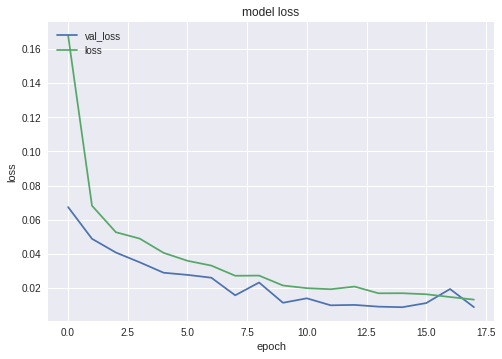

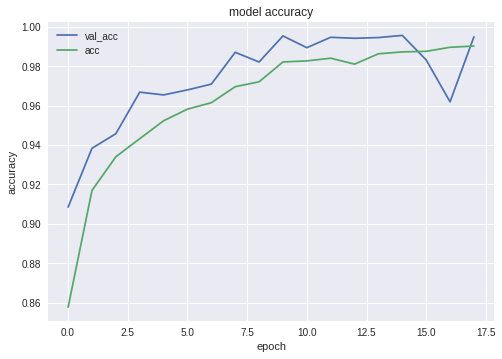

In [117]:
EPOCHS = 20
BATCH_SIZE = 275

early_stopping = EarlyStopping(monitor='val_loss', patience=3)


model = models.Sequential()
model.add(layers.Dense(1024, activation='relu',
                       input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(160, activation='relu'))
model.add(layers.Dropout(0.3))


model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))


model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(y_train.shape[1],activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['categorical_accuracy'])
history = model.fit(X_train, y_train,verbose=1, validation_data=(X_test,y_test), epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[early_stopping])
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


import matplotlib.pyplot as plt

print(history.history.keys())
# summarize history for loss
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val_loss', 'loss'], loc='upper left')
plt.show()

plt.plot(history.history['val_categorical_accuracy'])
plt.plot(history.history['categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_acc', 'acc'], loc='upper left')
plt.show()




```

model = models.Sequential()
model.add(layers.Dense(1024, activation='relu',
                       input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.3))


model.add(layers.Dense(160, activation='relu'))
model.add(layers.Dropout(0.3))


model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))


model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(y_train.shape[1],activation='softmax'))```



Test accuracy: 0.9949977262391997


In [0]:

def prepare_data(data):
    text_df = pd.DataFrame(data)
    print("row_df:{}".format(text_df))
    text_df[["iid", "style", "text"]] = text_df[["iid", "style", "text"]].applymap(lambda x: wakati(x)).fillna("")
    text_df[["iid", "style"]] = text_df[["iid", "style"]].applymap(lambda x: add_space_front_uppercase(x))
    text_df[["iid", "style"]] = text_df[["iid", "style"]].applymap(lambda x: add_space_color_size(x))
    text_df["tag"] = text_df[["tag"]].applymap(lambda x: tag_filter(x))
    print("filterd row_df:{}".format(text_df))

    df = text_df
    fileds = ["x", "y", "height","width" ]
    X = df[fileds]

    df_tag = load_tokanaize(df, "tag")
    X = X.join(df_tag)

    df_iid = load_tokanaize(df, "iid")
    X = X.join(df_iid)

    df_style = load_tokanaize(df, "style")
    X = X.join(df_style)

    df_style = load_tokanaize(df, "text")
    X = X.join(df_style)
    X = X.fillna(0)

    return X

In [0]:
token_path = "{}/tokenizer_{}.pickle"

def load_tokanaize(df, filed, ):
    token = None
    # loading
    with open(token_path.format(base_dir,filed), 'rb') as handle:
        token = pickle.load(handle)

    text_matrix = token.texts_to_matrix(df[filed], mode='count')
    df_temp = pd.DataFrame(text_matrix)
    column_size = len(df_temp.columns)
    print(filed)
    print(df_temp)
    print(column_size)
    columns = ["{}{}".format(filed, i) for i in range(column_size)]
    df_temp.columns = columns
    return df_temp


In [107]:
import json
text = '''[ {
  "tag" : null,
  "iid" : null,
  "style" : null,
  "text" : "",
  "href" : null,
  "label" : null,
  "x" : 0,
  "y" : 0,
  "height" : 0,
  "width" : 0,
  "value" : null,
  "location" : null,
  "size" : null,
  "tagName" : null,
  "searchCriteria" : null,
  "selected" : false,
  "wrappedDriver" : null,
  "displayed" : false,
  "rect" : null,
  "coordinates" : null,
  "wrappedElement" : null,
  "enabled" : false,
  "image" : false,
  "selectedOption" : null,
  "selectedOptions" : null,
  "selectedValue" : null,
  "selectedText" : null
}, {
  "tag" : null,
  "iid" : null,
  "style" : null,
  "text" : "",
  "href" : null,
  "label" : null,
  "x" : 0,
  "y" : 0,
  "height" : 0,
  "width" : 0,
  "value" : null,
  "location" : null,
  "size" : null,
  "tagName" : null,
  "searchCriteria" : null,
  "selected" : false,
  "wrappedDriver" : null,
  "displayed" : false,
  "rect" : null,
  "coordinates" : null,
  "wrappedElement" : null,
  "enabled" : false,
  "image" : false,
  "selectedOption" : null,
  "selectedOptions" : null,
  "selectedValue" : null,
  "selectedText" : null
}, {
  "tag" : null,
  "iid" : null,
  "style" : null,
  "text" : null,
  "href" : null,
  "label" : null,
  "x" : 450,
  "y" : 40,
  "height" : 0,
  "width" : 0,
  "value" : null,
  "location" : null,
  "size" : null,
  "tagName" : null,
  "searchCriteria" : null,
  "selected" : false,
  "wrappedDriver" : null,
  "displayed" : false,
  "rect" : null,
  "coordinates" : null,
  "wrappedElement" : null,
  "enabled" : false,
  "image" : false,
  "selectedOption" : null,
  "selectedOptions" : null,
  "selectedValue" : null,
  "selectedText" : null
}, {
  "tag" : null,
  "iid" : null,
  "style" : null,
  "text" : null,
  "href" : null,
  "label" : null,
  "x" : 79,
  "y" : 106,
  "height" : 0,
  "width" : 0,
  "value" : null,
  "location" : null,
  "size" : null,
  "tagName" : null,
  "searchCriteria" : null,
  "selected" : false,
  "wrappedDriver" : null,
  "displayed" : false,
  "rect" : null,
  "coordinates" : null,
  "wrappedElement" : null,
  "enabled" : false,
  "image" : false,
  "selectedOption" : null,
  "selectedOptions" : null,
  "selectedValue" : null,
  "selectedText" : null
}, {
  "tag" : null,
  "iid" : null,
  "style" : null,
  "text" : null,
  "href" : null,
  "label" : null,
  "x" : 143,
  "y" : 106,
  "height" : 0,
  "width" : 0,
  "value" : null,
  "location" : null,
  "size" : null,
  "tagName" : null,
  "searchCriteria" : null,
  "selected" : false,
  "wrappedDriver" : null,
  "displayed" : false,
  "rect" : null,
  "coordinates" : null,
  "wrappedElement" : null,
  "enabled" : false,
  "image" : false,
  "selectedOption" : null,
  "selectedOptions" : null,
  "selectedValue" : null,
  "selectedText" : null
}, {
  "tag" : null,
  "iid" : null,
  "style" : null,
  "text" : null,
  "href" : null,
  "label" : null,
  "x" : 215,
  "y" : 106,
  "height" : 0,
  "width" : 0,
  "value" : null,
  "location" : null,
  "size" : null,
  "tagName" : null,
  "searchCriteria" : null,
  "selected" : false,
  "wrappedDriver" : null,
  "displayed" : false,
  "rect" : null,
  "coordinates" : null,
  "wrappedElement" : null,
  "enabled" : false,
  "image" : false,
  "selectedOption" : null,
  "selectedOptions" : null,
  "selectedValue" : null,
  "selectedText" : null
}, {
  "tag" : null,
  "iid" : null,
  "style" : null,
  "text" : null,
  "href" : null,
  "label" : null,
  "x" : 272,
  "y" : 106,
  "height" : 0,
  "width" : 0,
  "value" : null,
  "location" : null,
  "size" : null,
  "tagName" : null,
  "searchCriteria" : null,
  "selected" : false,
  "wrappedDriver" : null,
  "displayed" : false,
  "rect" : null,
  "coordinates" : null,
  "wrappedElement" : null,
  "enabled" : false,
  "image" : false,
  "selectedOption" : null,
  "selectedOptions" : null,
  "selectedValue" : null,
  "selectedText" : null
}, {
  "tag" : null,
  "iid" : null,
  "style" : null,
  "text" : null,
  "href" : null,
  "label" : null,
  "x" : 364,
  "y" : 106,
  "height" : 0,
  "width" : 0,
  "value" : null,
  "location" : null,
  "size" : null,
  "tagName" : null,
  "searchCriteria" : null,
  "selected" : false,
  "wrappedDriver" : null,
  "displayed" : false,
  "rect" : null,
  "coordinates" : null,
  "wrappedElement" : null,
  "enabled" : false,
  "image" : false,
  "selectedOption" : null,
  "selectedOptions" : null,
  "selectedValue" : null,
  "selectedText" : null
}, {
  "tag" : null,
  "iid" : null,
  "style" : null,
  "text" : null,
  "href" : null,
  "label" : null,
  "x" : 453,
  "y" : 106,
  "height" : 0,
  "width" : 0,
  "value" : null,
  "location" : null,
  "size" : null,
  "tagName" : null,
  "searchCriteria" : null,
  "selected" : false,
  "wrappedDriver" : null,
  "displayed" : false,
  "rect" : null,
  "coordinates" : null,
  "wrappedElement" : null,
  "enabled" : false,
  "image" : false,
  "selectedOption" : null,
  "selectedOptions" : null,
  "selectedValue" : null,
  "selectedText" : null
}, {
  "tag" : null,
  "iid" : null,
  "style" : null,
  "text" : null,
  "href" : null,
  "label" : null,
  "x" : 550,
  "y" : 106,
  "height" : 0,
  "width" : 0,
  "value" : null,
  "location" : null,
  "size" : null,
  "tagName" : null,
  "searchCriteria" : null,
  "selected" : false,
  "wrappedDriver" : null,
  "displayed" : false,
  "rect" : null,
  "coordinates" : null,
  "wrappedElement" : null,
  "enabled" : false,
  "image" : false,
  "selectedOption" : null,
  "selectedOptions" : null,
  "selectedValue" : null,
  "selectedText" : null
} ]'''
sample = json.loads(text)
print(sample)
sample = pd.DataFrame(sample)
sample_df = prepare_data(sample)
print(sample_df)
print(sample_df.columns)

result = model.predict(sample_df)
print(result)
for resu in result:
  resu = np.argmax(resu)
  print(resu)

  resu = label_dic.get(resu)
  print(resu)


[{'tag': None, 'iid': None, 'style': None, 'text': '', 'href': None, 'label': None, 'x': 0, 'y': 0, 'height': 0, 'width': 0, 'value': None, 'location': None, 'size': None, 'tagName': None, 'searchCriteria': None, 'selected': False, 'wrappedDriver': None, 'displayed': False, 'rect': None, 'coordinates': None, 'wrappedElement': None, 'enabled': False, 'image': False, 'selectedOption': None, 'selectedOptions': None, 'selectedValue': None, 'selectedText': None}, {'tag': None, 'iid': None, 'style': None, 'text': '', 'href': None, 'label': None, 'x': 0, 'y': 0, 'height': 0, 'width': 0, 'value': None, 'location': None, 'size': None, 'tagName': None, 'searchCriteria': None, 'selected': False, 'wrappedDriver': None, 'displayed': False, 'rect': None, 'coordinates': None, 'wrappedElement': None, 'enabled': False, 'image': False, 'selectedOption': None, 'selectedOptions': None, 'selectedValue': None, 'selectedText': None}, {'tag': None, 'iid': None, 'style': None, 'text': None, 'href': None, 'labe

ValueError: ignored

###モデルの復元が正確かを検証

In [0]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.039125395782378024
Test accuracy: 0.9608679862029904


###テストデータの予測結果を一つずつ確認。

In [96]:
con = 0
length = 200
for i in range(length):
#   print(X_test[i:i+1])
  result = model.predict(X_test[i:i+1])
  
  
  predict_result = label_dic.get(np.argmax(result))
  y_label = label_dic.get(np.argmax(y_test[i:i+1]))
  if y_label != predict_result:
#     print('con',con)
    con += 1
    print('Result:', result)
    print('predict_label:', label_dic.get(np.argmax(result)),' y_label:', label_dic.get(np.argmax(y_test[i:i+1])))
print("con", con)
print("score", con/length)

Result: [[2.8999874e-04 1.3046800e-01 4.2887869e-01 2.0199080e-01 1.4272003e-01
  9.5652476e-02]]
predict_label: stock  y_label: skip
Result: [[0.00402916 0.1197044  0.60517555 0.09898148 0.06029789 0.11181153]]
predict_label: stock  y_label: outofstock
Result: [[3.5193996e-05 1.4439395e-01 3.8832471e-01 2.2191924e-01 1.5547034e-01
  8.9856550e-02]]
predict_label: stock  y_label: skip
Result: [[0.00402916 0.1197044  0.60517555 0.09898148 0.06029789 0.11181153]]
predict_label: stock  y_label: outofstock
Result: [[1.2720778e-17 2.8365874e-01 5.3190552e-02 3.9557937e-01 2.4751019e-01
  2.0061204e-02]]
predict_label: vari  y_label: skip
Result: [[0.00402916 0.1197044  0.60517555 0.09898148 0.06029789 0.11181153]]
predict_label: stock  y_label: outofstock
Result: [[0.00402916 0.1197044  0.60517555 0.09898148 0.06029789 0.11181153]]
predict_label: stock  y_label: outofstock
Result: [[0.0000000e+00 4.1018605e-01 1.0174526e-05 4.1293192e-01 1.7685208e-01
  1.9747344e-05]]
predict_label: vari  

##作成したモデルを保存する



###モデルを保存

In [120]:

# serialize model to JSON
model_json = model.to_json()
with open("model_015.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_015.h5")
print("Saved model to disk")

Saved model to disk


###モデルを読み込み

In [121]:

# load json and create model
json_file = open('model_015.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_015.h5")
print("Loaded model from disk")

Loaded model from disk


###モデルを使って検証

In [122]:

# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['categorical_accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

categorical_accuracy: 99.50%


###モデルと重みをダウンロード

In [0]:
files.download("model_015.json")


In [0]:
files.download("model_015.h5")